# Process Stations

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from climpyrical.gridding import transform_coords, find_element_wise_nearest_pos
from scipy.interpolate import NearestNDInterpolator

### Load station data for processing

In [21]:
# df_path = '/home/nannau/nrc_data/Interim_snow_rain_load_LR_composite_stations_delivered_v3.csv'
# df_path = '/home/nannau/nrc_data/Interim_hdd_Tmax_Tmin_delivered.csv'
# df_path = '/home/nannau/nrc_data/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
df_path = '/home/nannau/nrc_data/sl50_from_swe50_sdmax_lrs_composite_mss.csv'

df = pd.read_csv(df_path, index_col=None)#.dropna()
df_zero = pd.read_csv(df_path, index_col=None)


# station_dv = 'RL50 (kPa)'
station_dv = 'SL50 (kPa)'

# station_dv = 'HDD (degC-day)'

# transform into rotated pole and assign as new columns
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)
df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

df_zero = df.copy()

df = df[df[station_dv] != 0.0]

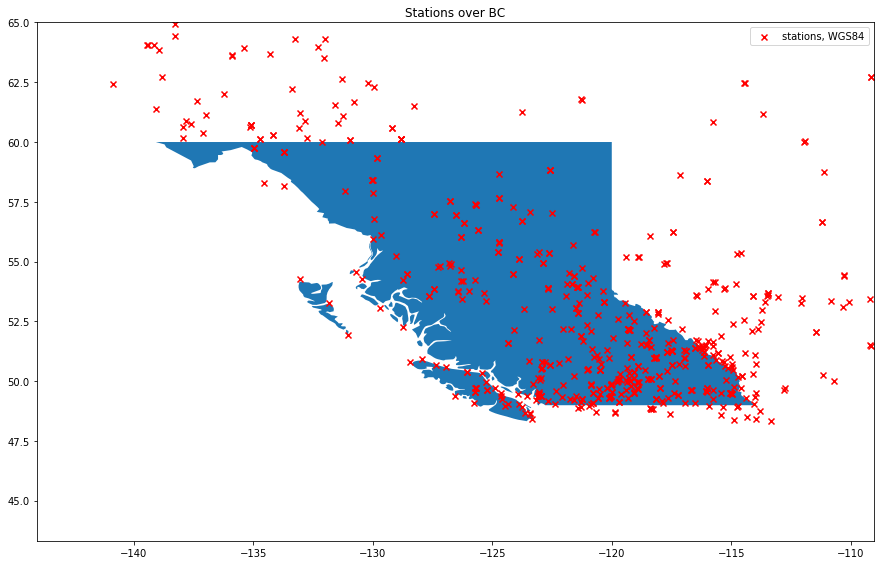

In [70]:
s = gpd.read_file('/home/nannau/nrc_data/ne_50m_admin_1_states_provinces.shp')

# select Canada only
c = s[s.iso_a2 == "CA"]
c = c[c.name == 'British Columbia']

fig, ax = plt.subplots(figsize=(15, 15))
c.plot(ax = ax)
ax.scatter(df.lon, df.lat, marker='x', color='r', label='stations, WGS84')
plt.legend()
ax.set_ylim(c.geometry.bounds.miny.values-5, c.geometry.bounds.maxy.values+5)
ax.set_xlim(c.geometry.bounds.minx.values-5, c.geometry.bounds.maxx.values+5)
plt.title("Stations over BC")
plt.savefig('stations_bc')

In [23]:
df.rlat.max()

36.222662646628834

### Open the pre-processed model

In [24]:
# dv = 'Rain-RL50'
# dv = 'heating_degree_days_per_time_period'
dv = 'snw'
ds = xr.open_dataset('./data/processed/pre_processed.nc')
ds

<xarray.Dataset>
Dimensions:  (rlat: 1510, rlon: 1550)
Coordinates:
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86
Data variables:
    snw      (rlat, rlon) float64 ...

### Match stations to grids in model
Find the nearest grid cells to the station locations

In [25]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

matched_df = pd.DataFrame({'ilocy': iy, 'ilocx': ix, station_dv: df[station_dv], 'rlat':df.rlat, 'rlon':df.rlon, 'lat': df.lat, 'lon':df.lon, 'station_name':df.station_name})
matched_df = matched_df.groupby(['ilocy', 'ilocx'], as_index=False).agg({station_dv: 'mean', 'rlat':'mean', 'rlon':'mean', 'lat': 'mean', 'lon': 'mean', 'station_name': 'first'})

iy = matched_df.ilocy.values
ix = matched_df.ilocx.values
station_vals = matched_df[station_dv].values

In [26]:
print(station_vals.shape, df.shape)

(1315,) (1586, 10)


Identify locations where the closest grid cell falls on a invalid model value

In [28]:
nan_index = np.isnan(ds[dv].values[iy, ix])
ixnan, iynan = matched_df.ilocx.values[nan_index], matched_df.ilocy.values[nan_index]
ixnan, iynan

(array([1254, 1313,  377,  343,  345,  310]),
 array([680, 752, 771, 818, 850, 915]))

Create an interpolator that can find the nearest valid model value at these locations

In [29]:
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

model_nan = ~np.isnan(ds[dv])
model_vals = ds[dv].values[iy, ix]

f = NearestNDInterpolator(np.stack([rlon[model_nan], rlat[model_nan]]).T, ds[dv].values[model_nan])

Replace those invalid values with their nearest neighbor based on above interpolator.

In [30]:
model_vals[nan_index] = f(np.stack([rlon[iynan, ixnan], rlat[iynan, ixnan]]).T)

Now each station should be matched with a value grid cell value

In [31]:
ratio = matched_df[station_dv]/model_vals
assert not np.any(np.isnan(ratio))

### Normalize the model mean to match that of the station distribution
Find a factor, $\beta$ such that the model mean $$\frac{\mu_m}{\beta} \approx \mu_s$$ where $\mu_s$ is the station mean. 

In [32]:
# choose starting value
station_vals_no_0 = station_vals[station_vals != 0.0]
model_vals_no_0 = model_vals[station_vals != 0.0]
start = np.nanmean(model_vals_no_0/station_vals_no_0)
# enter tolerances
tol = np.linspace(0.0, start+2, 10000)

if np.nanmean(station_vals_no_0 - model_vals_no_0) >= 0:
    rmtols = np.array([np.nanmean(station_vals_no_0 - (model_vals_no_0/t)) for t in tol])
    best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0][0]]

if np.nanmean(matched_df[station_dv] - model_vals) < 0:
    rmtols = np.array([np.nanmean(matched_df[station_dv] - (model_vals/t)) for t in tol])
    best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0][0]]

print(tol.min(), "<=", best_tol, "<=", tol.max())

# apply correction
model_vals_corrected = model_vals/best_tol
mean_corrected = ds[dv].values/best_tol
ratio = station_vals/model_vals_corrected



# calculate ratios with applied correction
matched_df = matched_df.assign(ratio=ratio)

/home/nannau/tri/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


0.0 <= 0.6652619443881025 <= 2.7728029103529126


In [33]:
matched_df = matched_df.assign(model_vals = model_vals, best_tol = best_tol)

In [34]:
# final_df = pd.concat([matched_df, df_zero[df_zero[station_dv] == 0.0]], sort=False)

In [35]:
# final_df.to_csv('./data/processed/processed_station.csv')
matched_df.to_csv('./data/processed/processed_station.csv')

matched_df

,ilocy,ilocx,SL50 (kPa),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,558,1009,0.976982,-4.286849,10.373390,42.27560,-82.9556,WINDSOR A,1.078971,0.602379,0.665262
1,559,1009,1.228341,-4.227125,10.379271,42.33330,-82.9333,WINDSOR RIVERSIDE,1.348878,0.605814,0.665262
2,573,1019,1.520361,-3.597423,10.826373,42.87000,-82.1800,ONR-3603,1.429491,0.707551,0.665262
3,573,1025,2.065695,-3.587641,11.086397,42.83000,-81.8300,ONR-3602,1.954558,0.703089,0.665262
4,576,1017,1.494511,-3.494586,10.713492,42.99220,-82.3047,SARNIA AIRPORT,1.345183,0.739112,0.665262
...,...,...,...,...,...,...,...,...,...,...,...
1310,1322,640,1.232479,29.595134,-5.969464,76.23165,-119.3315,MOULD BAY A,0.623250,1.315559,0.665262
1311,1362,741,1.592493,31.345756,-1.484925,78.78330,-103.5330,ISACHSEN,0.637347,1.662243,0.665262
1312,1391,826,0.893233,32.645419,2.272431,79.98330,-85.9333,EUREKA A,0.305200,1.947032,0.665262
1313,1392,826,1.325107,32.661978,2.269768,80.00000,-85.9300,SCD-NT017,0.452763,1.947032,0.665262


In [36]:
matched_df.head()

,ilocy,ilocx,SL50 (kPa),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,558,1009,0.976982,-4.286849,10.373390,42.2756,-82.9556,WINDSOR A,1.078971,0.602379,0.665262
1,559,1009,1.228341,-4.227125,10.379271,42.3333,-82.9333,WINDSOR RIVERSIDE,1.348878,0.605814,0.665262
2,573,1019,1.520361,-3.597423,10.826373,42.8700,-82.1800,ONR-3603,1.429491,0.707551,0.665262
3,573,1025,2.065695,-3.587641,11.086397,42.8300,-81.8300,ONR-3602,1.954558,0.703089,0.665262
4,576,1017,1.494511,-3.494586,10.713492,42.9922,-82.3047,SARNIA AIRPORT,1.345183,0.739112,0.665262


# NRC Locations

In [37]:
nrc_path = '/home/nannau/nrc_data/NBCC_2020_new_coords.xlsm'
df_nrc = pd.read_excel(nrc_path).dropna()

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# get rotated pole coordinates
rlon_st, rlat_st = transform_coords(df_nrc['2020 Longitude'].values, df_nrc['2020 Latitude'].values)
df_nrc = df_nrc.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

In [38]:
# find indices of the station locations
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df_nrc.rlon.values, 
            df_nrc.rlat.values
)
# write to new dataframe
df_nrc_matched = pd.DataFrame(
    {'ilocy': iy, 
     'ilocx': ix, 
     'Location': df_nrc.Location, 
     'rlat':df_nrc.rlat, 
     'rlon':df_nrc.rlon, 
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
)

df_nrc_matched.to_csv('./data/processed/nrc_locations.csv')